In [1]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import itertools
import numpy as np

Множественные сравнения нужны для того, чтобы узнать, какие выборки имеют статистически значимое различие. Если у нас 2 выборки, то парное сравнение даст уровень значимости 0,05. С ростом числа выборок, например, 8 выборок, мы проводим попарное сравнение 8*(8-1)/2 = 28 сравнений. И вероятность встретить хотя бы одно статистически значимое различие увеличивается до 0,496.

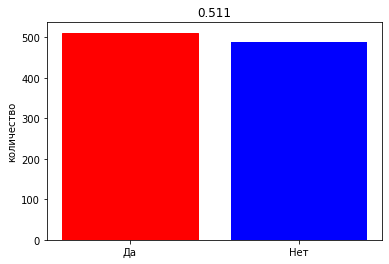

In [2]:
M = 0
D = 1

def ttest(a, b):
    se = np.sqrt(a['SD']**2/a['N'] + b['SD']**2/b['N'])
    t = (a['Mx'] - b['Mx'])/se
    dfreedom = a['N'] + b['N'] - 2
    return stats.t.sf(np.abs(t), dfreedom)*2

# n - элементов в выборке
# m - количество выборок
# a -  вероятность
def false_alarm(m, n, a):
    trys = 1000 # количество экспериментов
    hist = {'Да':0, 'Нет':0} # результаты сравнений     
    data = list(range(m)) # инициализация групп с выборками
    
    # запускаем trys экспериментов
    for i in range(trys):
        
        # наполняем m выборок, для ускорения сразу их агрегируем по SD, Mx, N
        for j in range(m):
            dt = stats.norm.rvs(loc=M, scale=D, size=n)
            data[j] = {'SD':np.std(dt, ddof = 1), 'Mx':np.mean(dt), 'N':n}
        
        #сравниваем выборки по 2 группы, перебор можно реализовать с помощью двух циклов или воспользоваться itertools
        for first, second in itertools.combinations(data, 2):
            if ttest(first, second) <= a:
                hist['Да']+=1
                break
        else:
            hist['Нет']+=1

    # рисуем гитограмму частот
    barlist = plt.bar(hist.keys(), hist.values(), color='b')
    barlist[0].set_color('r')
    plt.title(round(hist['Да'] / trys,3))
    plt.ylabel('количество')
    plt.show()
    

false_alarm(8,30,0.05)

Вероятность ошибки первого рода (получить вероятность значимых различий там, где их нет) возрастает пропорционально количеству групп, которые мы сравниваем попарно (количество гипотез, которые мы проверяем в нашем эксперименте). 

Чтобы корректно отобразить вероятность встретить хотя бы одно различие при попарном сравнении, нужно использовать Поправку Бонферрони уровня значимости альфа. Нужно поделить альфа на количество сравнений. В нашем случае на 28.

Если мы хотим удержать вероятность ошибки I рода на уровне 0,05, то делим это уровень на количество попарных сравнений. Новый показатель альфа используем в нашем эксперименте. 

In [3]:
0.05 / 28

0.0017857142857142859

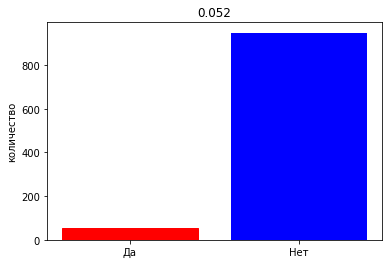

In [4]:
false_alarm(8,30,0.0017857142857142859)

Если мы бы принимали различия статистически значимыми на уровне нового коэфициента альфа = 0.0017857142857142859, то только в 4,4% случаях мы бы получили хотя бы одно значимое различие.

In [5]:
20 * 19 / 2

190.0

In [6]:
0.05 / 190

0.0002631578947368421

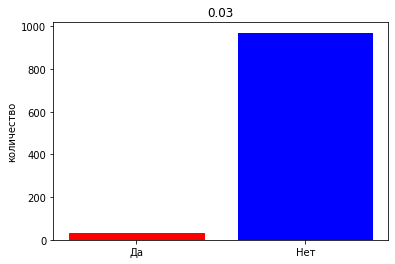

In [7]:
false_alarm(20,30,0.0002631578947368421)

Поправка позволяет избежать ложных открытий. Но при этом поправка Бонферонни сильно понижает уровень значимости. Установить различия достаточно трудно. Поэтому разработали другой метод, менее консервативный: Поправка Тьюки.

Критерий Тьюки похож на t-test, попарно сравнивает комбинации средних, однако, здесь по другому расчитывается SE и по-другому расчитывается сам t критерий. С помощью критерия Тьюки можно рассчитать доверительный интервал между разницей средних значений групп A и Б. И если такой доверительный интервал не включает в себя 0, то можно отклонить гипотезу о равенстве средних. 

Вернемся к сравнению экспрессии генов в четырех исследованиях:

In [8]:
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
data_stepik = pd.read_csv('https://stepik.org/media/attachments/lesson/8083/genetherapy.csv')
MultiComp = MultiComparison(data_stepik['expr'], data_stepik['Therapy'])
MultiComp.tukeyhsd().summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,-0.9333,0.9,-5.5961,3.7294,False
A,C,-5.3333,0.0189,-9.9961,-0.6706,True
A,D,-7.4,0.001,-12.0628,-2.7372,True
B,C,-4.4,0.0712,-9.0628,0.2628,False
B,D,-6.4667,0.0029,-11.1294,-1.8039,True
C,D,-2.0667,0.6296,-6.7294,2.5961,False


Значимо между собой отличаются: AC, AD, BD, так как доверительные интервалы разниц средних не включают в себя 0 (ноль).